In [2]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from tensorflow.keras.utils import img_to_array



# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = r'C:\Users\akagg\Downloads\archive\Dataset\Train\Fake1'

files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
        
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = (img - 127.5) / 127.5
        imh = img.astype(float)
        _img.append(img_to_array(img))
# Batch size and dataset
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)
# Generator
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))



    return model
# Generator created
generator = Generator()
generator.summary()
# Discrimitor

def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

# Discrimitor Created
discriminator = Discriminator()
discriminator.summary()

noise = np.random.normal(-1,1,(1,100))
img = generator(noise)

optimizer = tf.keras.optimizers.legacy.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)


    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss
import time
def train(epochs,dataset):

    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))




train(1000,dataset)
generator.save('generator.h5')
discriminator.save("discriminator.h5")

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 78.28it/s]




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                      

C:\Users\akagg\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\legacy\rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



Epoch : 1


C:\Users\akagg\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 Time:17.0
Generator Loss: 0.5251317024230957 Discriminator Loss: 1.4136260747909546

Epoch : 2
 Time:15.0
Generator Loss: 0.016531992703676224 Discriminator Loss: 4.168893337249756

Epoch : 3
 Time:14.0
Generator Loss: 17.401226043701172 Discriminator Loss: 0.10913374274969101

Epoch : 4
 Time:15.0
Generator Loss: 0.0024587130174040794 Discriminator Loss: 6.093887805938721

Epoch : 5
 Time:14.0
Generator Loss: 17.969562530517578 Discriminator Loss: 0.39032265543937683

Epoch : 6
 Time:14.0
Generator Loss: 7.24554967880249 Discriminator Loss: 0.005954669788479805

Epoch : 7
 Time:14.0
Generator Loss: 8.324498776346445e-05 Discriminator Loss: 9.41015911102295

Epoch : 8
 Time:14.0
Generator Loss: 11.684460639953613 Discriminator Loss: 0.16130389273166656

Epoch : 9
 Time:14.0
Generator Loss: 3.046706199645996 Discriminator Loss: 0.08826618641614914

Epoch : 10
 Time:15.0
Generator Loss: 1.9750621318817139 Discriminator Loss: 0.18599915504455566

Epoch : 11
 Time:14.0
Generator Loss: 4.9

 Time:14.0
Generator Loss: 0.1787528693675995 Discriminator Loss: 2.1839826107025146

Epoch : 87
 Time:14.0
Generator Loss: 2.066757917404175 Discriminator Loss: 0.6344411969184875

Epoch : 88
 Time:15.0
Generator Loss: 1.2265549898147583 Discriminator Loss: 0.4341661334037781

Epoch : 89
 Time:15.0
Generator Loss: 2.0895984172821045 Discriminator Loss: 0.22361689805984497

Epoch : 90
 Time:15.0
Generator Loss: 4.445986747741699 Discriminator Loss: 0.021952398121356964

Epoch : 91
 Time:15.0
Generator Loss: 1.456120491027832 Discriminator Loss: 0.31677955389022827

Epoch : 92
 Time:15.0
Generator Loss: 1.8193998336791992 Discriminator Loss: 0.2896632254123688

Epoch : 93
 Time:16.0
Generator Loss: 1.2163678407669067 Discriminator Loss: 0.41082602739334106

Epoch : 94
 Time:15.0
Generator Loss: 2.517625093460083 Discriminator Loss: 0.583315372467041

Epoch : 95
 Time:15.0
Generator Loss: 0.8507996797561646 Discriminator Loss: 0.7058178782463074

Epoch : 96
 Time:15.0
Generator Loss: 0.3

 Time:16.0
Generator Loss: 1.563118815422058 Discriminator Loss: 0.261070191860199

Epoch : 171
 Time:16.0
Generator Loss: 4.314167499542236 Discriminator Loss: 0.09988483786582947

Epoch : 172
 Time:16.0
Generator Loss: 3.2621030807495117 Discriminator Loss: 0.048724085092544556

Epoch : 173
 Time:16.0
Generator Loss: 3.3776402473449707 Discriminator Loss: 0.04677775502204895

Epoch : 174
 Time:15.0
Generator Loss: 3.7698311805725098 Discriminator Loss: 0.041390176862478256

Epoch : 175
 Time:15.0
Generator Loss: 7.478302001953125 Discriminator Loss: 0.011064577847719193

Epoch : 176
 Time:15.0
Generator Loss: 3.2158522605895996 Discriminator Loss: 0.05080273002386093

Epoch : 177
 Time:15.0
Generator Loss: 2.937757968902588 Discriminator Loss: 0.07803531736135483

Epoch : 178
 Time:15.0
Generator Loss: 2.306978225708008 Discriminator Loss: 0.1561993658542633

Epoch : 179
 Time:16.0
Generator Loss: 3.2325406074523926 Discriminator Loss: 0.3868609368801117

Epoch : 180
 Time:16.0
Gener

 Time:14.0
Generator Loss: 1.8351941108703613 Discriminator Loss: 0.42282673716545105

Epoch : 255
 Time:15.0
Generator Loss: 2.323528528213501 Discriminator Loss: 0.2703213691711426

Epoch : 256
 Time:15.0
Generator Loss: 2.758823871612549 Discriminator Loss: 0.22713059186935425

Epoch : 257
 Time:14.0
Generator Loss: 1.719761610031128 Discriminator Loss: 0.35347965359687805

Epoch : 258
 Time:14.0
Generator Loss: 5.0823822021484375 Discriminator Loss: 0.8120875358581543

Epoch : 259
 Time:14.0
Generator Loss: 0.2487906664609909 Discriminator Loss: 1.9415535926818848

Epoch : 260
 Time:15.0
Generator Loss: 1.7701807022094727 Discriminator Loss: 0.2550177574157715

Epoch : 261
 Time:15.0
Generator Loss: 1.9087975025177002 Discriminator Loss: 0.3060341477394104

Epoch : 262
 Time:15.0
Generator Loss: 2.6870317459106445 Discriminator Loss: 0.2933341860771179

Epoch : 263
 Time:14.0
Generator Loss: 1.7810003757476807 Discriminator Loss: 0.26296260952949524

Epoch : 264
 Time:15.0
Generato

 Time:14.0
Generator Loss: 0.8770225048065186 Discriminator Loss: 0.7530056238174438

Epoch : 339
 Time:15.0
Generator Loss: 1.8840811252593994 Discriminator Loss: 0.22840219736099243

Epoch : 340
 Time:14.0
Generator Loss: 2.2970852851867676 Discriminator Loss: 0.1579817831516266

Epoch : 341
 Time:15.0
Generator Loss: 2.884392261505127 Discriminator Loss: 0.09538181126117706

Epoch : 342
 Time:15.0
Generator Loss: 2.937574863433838 Discriminator Loss: 0.08048111200332642

Epoch : 343
 Time:15.0
Generator Loss: 4.0832414627075195 Discriminator Loss: 0.041548050940036774

Epoch : 344
 Time:15.0
Generator Loss: 4.547548294067383 Discriminator Loss: 0.02136717364192009

Epoch : 345
 Time:15.0
Generator Loss: 4.165289878845215 Discriminator Loss: 0.034820184111595154

Epoch : 346
 Time:14.0
Generator Loss: 3.7946481704711914 Discriminator Loss: 0.06642679870128632

Epoch : 347
 Time:14.0
Generator Loss: 3.695136070251465 Discriminator Loss: 0.1148817166686058

Epoch : 348
 Time:14.0
Gener

 Time:14.0
Generator Loss: 4.161925315856934 Discriminator Loss: 0.030439812690019608

Epoch : 423
 Time:15.0
Generator Loss: 4.986638069152832 Discriminator Loss: 0.02301607094705105

Epoch : 424
 Time:14.0
Generator Loss: 7.593701362609863 Discriminator Loss: 0.007651984691619873

Epoch : 425
 Time:15.0
Generator Loss: 5.760194301605225 Discriminator Loss: 0.008236772380769253

Epoch : 426
 Time:14.0
Generator Loss: 3.612751007080078 Discriminator Loss: 0.06166337803006172

Epoch : 427
 Time:15.0
Generator Loss: 5.401562690734863 Discriminator Loss: 0.1562347561120987

Epoch : 428
 Time:14.0
Generator Loss: 0.211927130818367 Discriminator Loss: 2.5218565464019775

Epoch : 429
 Time:14.0
Generator Loss: 19.012773513793945 Discriminator Loss: 3.6145763397216797

Epoch : 430
 Time:15.0
Generator Loss: 5.585857391357422 Discriminator Loss: 0.2471398562192917

Epoch : 431
 Time:14.0
Generator Loss: 2.2084178924560547 Discriminator Loss: 0.16031284630298615

Epoch : 432
 Time:15.0
Generato

 Time:15.0
Generator Loss: 7.532594680786133 Discriminator Loss: 1.2621021270751953

Epoch : 507
 Time:14.0
Generator Loss: 3.9305927753448486 Discriminator Loss: 0.43329307436943054

Epoch : 508
 Time:15.0
Generator Loss: 3.336556911468506 Discriminator Loss: 0.10353494435548782

Epoch : 509
 Time:15.0
Generator Loss: 3.2554359436035156 Discriminator Loss: 0.08052194863557816

Epoch : 510
 Time:15.0
Generator Loss: 3.8609228134155273 Discriminator Loss: 0.0659908652305603

Epoch : 511
 Time:14.0
Generator Loss: 2.6169023513793945 Discriminator Loss: 0.10318431258201599

Epoch : 512
 Time:14.0
Generator Loss: 5.124759197235107 Discriminator Loss: 0.11595044285058975

Epoch : 513
 Time:15.0
Generator Loss: 2.206782102584839 Discriminator Loss: 0.1403680443763733

Epoch : 514
 Time:15.0
Generator Loss: 3.2613327503204346 Discriminator Loss: 0.28603750467300415

Epoch : 515
 Time:14.0
Generator Loss: 0.8223568201065063 Discriminator Loss: 0.6198354363441467

Epoch : 516
 Time:14.0
Generat

 Time:15.0
Generator Loss: 2.055341958999634 Discriminator Loss: 0.1796940267086029

Epoch : 591
 Time:15.0
Generator Loss: 6.484100341796875 Discriminator Loss: 0.5279023051261902

Epoch : 592
 Time:14.0
Generator Loss: 2.258042812347412 Discriminator Loss: 0.17075780034065247

Epoch : 593
 Time:15.0
Generator Loss: 3.7052838802337646 Discriminator Loss: 0.3887999355792999

Epoch : 594
 Time:15.0
Generator Loss: 0.7739817500114441 Discriminator Loss: 0.6589668989181519

Epoch : 595
 Time:15.0
Generator Loss: 18.364362716674805 Discriminator Loss: 2.9504330158233643

Epoch : 596
 Time:14.0
Generator Loss: 7.803445816040039 Discriminator Loss: 0.6900915503501892

Epoch : 597
 Time:15.0
Generator Loss: 4.587157249450684 Discriminator Loss: 0.07431767880916595

Epoch : 598
 Time:15.0
Generator Loss: 1.6890537738800049 Discriminator Loss: 0.22820019721984863

Epoch : 599
 Time:14.0
Generator Loss: 3.624763011932373 Discriminator Loss: 0.3153926730155945

Epoch : 600
 Time:15.0
Generator Lo

 Time:15.0
Generator Loss: 7.637513160705566 Discriminator Loss: 0.6155706644058228

Epoch : 675
 Time:14.0
Generator Loss: 1.7259165048599243 Discriminator Loss: 0.2690353989601135

Epoch : 676
 Time:14.0
Generator Loss: 4.138175964355469 Discriminator Loss: 0.5519506931304932

Epoch : 677
 Time:14.0
Generator Loss: 2.983426332473755 Discriminator Loss: 0.07726172357797623

Epoch : 678
 Time:14.0
Generator Loss: 3.245330810546875 Discriminator Loss: 0.09613419324159622

Epoch : 679
 Time:14.0
Generator Loss: 3.9828169345855713 Discriminator Loss: 0.07440736889839172

Epoch : 680
 Time:14.0
Generator Loss: 5.322220325469971 Discriminator Loss: 0.020819509401917458

Epoch : 681
 Time:14.0
Generator Loss: 1.7842025756835938 Discriminator Loss: 0.20510812103748322

Epoch : 682
 Time:14.0
Generator Loss: 8.790953636169434 Discriminator Loss: 1.3148773908615112

Epoch : 683
 Time:14.0
Generator Loss: 1.8226327896118164 Discriminator Loss: 0.19695477187633514

Epoch : 684
 Time:15.0
Generato

 Time:14.0
Generator Loss: 1.5272698402404785 Discriminator Loss: 0.2647857367992401

Epoch : 759
 Time:15.0
Generator Loss: 5.641862869262695 Discriminator Loss: 0.9831468462944031

Epoch : 760
 Time:15.0
Generator Loss: 2.8835830688476562 Discriminator Loss: 0.09591703116893768

Epoch : 761
 Time:14.0
Generator Loss: 3.5337791442871094 Discriminator Loss: 0.09499466419219971

Epoch : 762
 Time:14.0
Generator Loss: 1.819628357887268 Discriminator Loss: 0.20382022857666016

Epoch : 763
 Time:15.0
Generator Loss: 5.197906970977783 Discriminator Loss: 0.583831250667572

Epoch : 764
 Time:14.0
Generator Loss: 3.931917190551758 Discriminator Loss: 0.04314500838518143

Epoch : 765
 Time:15.0
Generator Loss: 3.313690423965454 Discriminator Loss: 0.057190604507923126

Epoch : 766
 Time:14.0
Generator Loss: 1.901793360710144 Discriminator Loss: 0.18961764872074127

Epoch : 767
 Time:14.0
Generator Loss: 5.727339267730713 Discriminator Loss: 0.6905143857002258

Epoch : 768
 Time:14.0
Generator 

 Time:15.0
Generator Loss: 6.599607467651367 Discriminator Loss: 0.9852959513664246

Epoch : 843
 Time:15.0
Generator Loss: 6.022464275360107 Discriminator Loss: 0.10207097232341766

Epoch : 844
 Time:15.0
Generator Loss: 4.080843925476074 Discriminator Loss: 0.03080473653972149

Epoch : 845
 Time:15.0
Generator Loss: 1.4001119136810303 Discriminator Loss: 0.2987273931503296

Epoch : 846
 Time:15.0
Generator Loss: 4.753968238830566 Discriminator Loss: 0.550150454044342

Epoch : 847
 Time:15.0
Generator Loss: 3.4952316284179688 Discriminator Loss: 0.057971689850091934

Epoch : 848
 Time:15.0
Generator Loss: 4.729650974273682 Discriminator Loss: 0.04319163039326668

Epoch : 849
 Time:15.0
Generator Loss: 1.9186744689941406 Discriminator Loss: 0.17486265301704407

Epoch : 850
 Time:15.0
Generator Loss: 4.422575950622559 Discriminator Loss: 0.3055831789970398

Epoch : 851
 Time:15.0
Generator Loss: 1.7287484407424927 Discriminator Loss: 0.23230823874473572

Epoch : 852
 Time:15.0
Generator

 Time:17.0
Generator Loss: 4.393890380859375 Discriminator Loss: 0.56058669090271

Epoch : 927
 Time:16.0
Generator Loss: 2.2398948669433594 Discriminator Loss: 0.1623936891555786

Epoch : 928
 Time:17.0
Generator Loss: 4.291429042816162 Discriminator Loss: 0.21441195905208588

Epoch : 929
 Time:18.0
Generator Loss: 1.820797085762024 Discriminator Loss: 0.19262245297431946

Epoch : 930
 Time:18.0
Generator Loss: 4.459321975708008 Discriminator Loss: 0.5552783608436584

Epoch : 931
 Time:18.0
Generator Loss: 7.388616561889648 Discriminator Loss: 0.008126970380544662

Epoch : 932
 Time:18.0
Generator Loss: 3.916309356689453 Discriminator Loss: 0.027012303471565247

Epoch : 933
 Time:19.0
Generator Loss: 1.3350896835327148 Discriminator Loss: 0.33760547637939453

Epoch : 934
 Time:18.0
Generator Loss: 6.783910751342773 Discriminator Loss: 0.8988009095191956

Epoch : 935
 Time:18.0
Generator Loss: 5.13129997253418 Discriminator Loss: 0.08520805090665817

Epoch : 936
 Time:18.0
Generator Lo

C:\Users\akagg\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
pwd()

'C:\\Users\\akagg'

1/1 [==============================] - 2s 2s/step


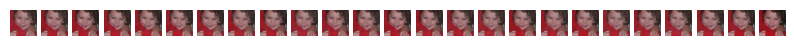

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

generator = load_model(r'C:\Users\akagg\Downloads\archive\Dataset\Deepfake\generator.h5')

# Function to generate images
def generate_images(generator, latent_dim, num_images=5):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0  # Scale pixel values to [0, 1]
    return generated_images

# Generate and plot images
num_images = 25
generated_images = generate_images(generator, latent_dim=100, num_images=num_images)

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()


In [16]:
# Load the discriminator model
discriminator = load_model(r'C:\Users\akagg\Downloads\archive\Dataset\Deepfake\discriminator.h5')

# Function to test generated images using the discriminator
def test_discriminator(discriminator, images):
    # Normalize the pixel values to [-1, 1]
    images = (images - 0.5) * 2
    # Predict the authenticity of the images
    predictions = discriminator.predict(images)
    return predictions

# Test the generated images using the discriminator
predictions = test_discriminator(discriminator, generated_images)

# Print the predictions
print("Predictions for the generated images:")
for i, pred in enumerate(predictions):
    print("Image {}: {:.2f}% Real, {:.2f}% Fake".format(i+1, pred[0]*100, (1-pred[0])*100))


1/1 [==============================] - 0s 152ms/step
Predictions for the generated images:
Image 1: 0.00% Real, 100.00% Fake
Image 2: 0.00% Real, 100.00% Fake
Image 3: 0.00% Real, 100.00% Fake
Image 4: 0.00% Real, 100.00% Fake
Image 5: 0.00% Real, 100.00% Fake
Image 6: 0.00% Real, 100.00% Fake
Image 7: 0.00% Real, 100.00% Fake
Image 8: 0.00% Real, 100.00% Fake
Image 9: 0.00% Real, 100.00% Fake
Image 10: 0.00% Real, 100.00% Fake
Image 11: 0.00% Real, 100.00% Fake
Image 12: 0.00% Real, 100.00% Fake
Image 13: 0.00% Real, 100.00% Fake
Image 14: 0.00% Real, 100.00% Fake
Image 15: 0.00% Real, 100.00% Fake
Image 16: 0.00% Real, 100.00% Fake
Image 17: 0.00% Real, 100.00% Fake
Image 18: 0.00% Real, 100.00% Fake
Image 19: 0.00% Real, 100.00% Fake
Image 20: 0.00% Real, 100.00% Fake
Image 21: 0.00% Real, 100.00% Fake
Image 22: 0.00% Real, 100.00% Fake
Image 23: 0.00% Real, 100.00% Fake
Image 24: 0.00% Real, 100.00% Fake
Image 25: 0.00% Real, 100.00% Fake


In [24]:
import cv2
SIZE = 128
# Function to load and preprocess images
def load_and_preprocess_images(image_paths, size=(SIZE, SIZE)):
    loaded_images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, size)
        img = (img - 127.5) / 127.5  # Normalize pixel values to [-1, 1]
        loaded_images.append(img)
    return np.array(loaded_images)

# Example usage:
image_paths = [r"C:\Users\akagg\Downloads\archive\Dataset\Test\Real\real_94.jpg"]  # List of paths to your sample images
sample_images = load_and_preprocess_images(image_paths)

# Test the sample images using the discriminator
predictions = test_discriminator(discriminator, sample_images)

# Print the predictions
print("Predictions for the sample images:")
for i, pred in enumerate(predictions):
    print("Image {}: {:.2f}% Real, {:.2f}% Fake".format(i+1, pred[0]*100, (1-pred[0])*100))


1/1 [==============================] - 0s 33ms/step
Predictions for the sample images:
Image 1: 99.97% Real, 0.03% Fake


In [34]:
import os
SIZE = 128
def load_and_preprocess_images_from_folder(folder_path, size=(SIZE, SIZE)):
    loaded_images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, size)
            img = (img - 127.5) / 127.5  # Normalize pixel values to [-1, 1]
            loaded_images.append(img)
        else:
            print(f"Warning: Unable to read image '{img_path}'. Skipping...")
    return np.array(loaded_images)

# Example usage:
folder_path = r'C:\Users\akagg\Downloads\archive\Dataset\Test\test1'  # Folder containing sample images
sample_images = load_and_preprocess_images_from_folder(folder_path)

# Test the sample images using the discriminator
predictions = test_discriminator(discriminator, sample_images)

# Print the predictions
print("Predictions for the sample images:")
for i, pred in enumerate(predictions):
    print("Image {}: {:.2f}% Real, {:.2f}% Fake".format(i+1, pred[0]*100, (1-pred[0])*100))


1/1 [==============================] - 0s 57ms/step
Predictions for the sample images:
Image 1: 100.00% Real, 0.00% Fake
Image 2: 8.12% Real, 91.88% Fake
Image 3: 99.96% Real, 0.04% Fake
Image 4: 99.10% Real, 0.90% Fake
Image 5: 99.07% Real, 0.93% Fake
Image 6: 99.99% Real, 0.01% Fake
Image 7: 0.00% Real, 100.00% Fake
Image 8: 79.87% Real, 20.13% Fake
